# Multas de tránsito en USA

Las infracciones de tráfico siguieron a la invención del automóvil: la primera multa de tráfico en los Estados Unidos supuestamente se le dio a un taxista de la ciudad de Nueva York el 20 de mayo de 1899 por ir a la vertiginosa velocidad de 12 millas por hora (aprox. 19.3 km/h). Desde entonces, se han emitido innumerables citaciones por infracciones de tránsito en todo el país, y los estados han cosechado miles de millones de dólares en ingresos de los infractores.

Las infracciones de tránsito generalmente se dividen en tipos de infracciones mayores y menores. El tipo más leve son las infracciones de estacionamiento, que no se cuentan en el historial de manejo, aunque una persona puede ser arrestada por infracciones no pagadas.

El tipo más común de infracción de tránsito es la infracción del límite de velocidad. Los límites de velocidad están definidos por estado.

El dataset fue obtenido de Kaggle: https://www.kaggle.com/datasets/felix4guti/traffic-violations-in-usa

In [1]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import curve_fit
import matplotlib.dates as mdates
matplotlib.rcParams['figure.figsize'] = [16,5]
import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import stats
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### Gráfica de la serie original - Lectura de datos

In [2]:
# Carga del dataset
inputfile="Traffic_Violations.csv"
print('Input file is:', inputfile)
df = pd.read_csv(inputfile)
df = df.rename(columns={'Date Of Stop': 'fecha_detencion'})
df = df.set_index(pd.DatetimeIndex(df['fecha_detencion']))
df.sort_index(ascending=True, inplace=True)
df["Count"] = 1
df = df["Count"]

df = df.groupby("fecha_detencion").count()
# Informacion general
df.info()


Input file is: Traffic_Violations.csv
<class 'pandas.core.series.Series'>
DatetimeIndex: 1822 entries, 2012-01-01 to 2016-12-27
Series name: Count
Non-Null Count  Dtype
--------------  -----
1822 non-null   int64
dtypes: int64(1)
memory usage: 28.5 KB


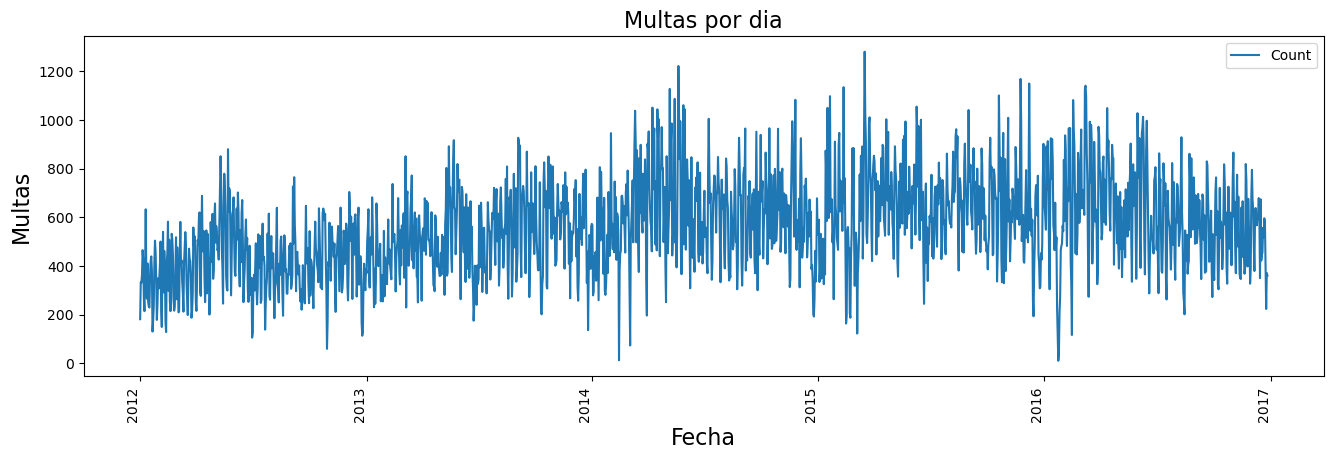

In [3]:
matplotlib.rcParams['figure.figsize'] = [16,5]
plt.figure()
ax = df.plot(y='Count', rot=90)
ax.set_title("Multas por dia", fontsize=16)
ax.set_ylabel("Multas", fontsize=16)
ax.set_xlabel("Fecha", fontsize=16)
plt.legend(loc='best')
plt.show()

## Estacionariedad y Preprocesamiento

#### Analisis preliminar de autocorrelación

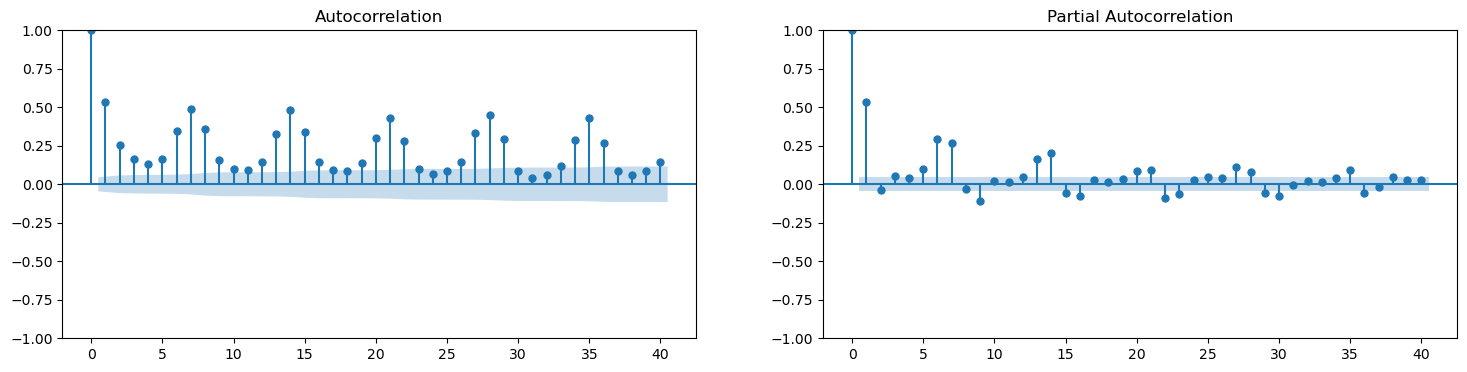

In [4]:
fig, ax = plt.subplots(1,2,figsize=(18,4))
plot_acf(df, lags=40, ax=ax[0])
plot_pacf(df, lags=40, method='ywm', ax=ax[1])
plt.show()

In [5]:
adfuller(df)
# Para que sea estacionaria el p-valor < 0.05 entonces rechazo H0 y puedo suponer que la serie es estacionaria

(-4.119046512800142,
 0.0009006481817216397,
 25,
 1796,
 {'1%': -3.433996253313391,
  '5%': -2.863150617970021,
  '10%': -2.5676274409973163},
 22927.832958824423)

In [6]:
kpss(df)
# Para que sea estacionaria el p-valor > 0.05 entonces no rechazo H0 y puedo suponer que la serie es estacionaria.

(4.591451820394207,
 0.01,
 19,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

#### Conclusión
Para  DF, tenemos un p-valor chico, lo cual indicaria que la serie puede ser estacionaria, para que la afirmación tome relevancia necesitamos que el p-valor de kpss sea grande, y vemos que no logra serlo, por lo que la serie no cumple con estacionariedad. 

#### Aplicación de Box-Cox

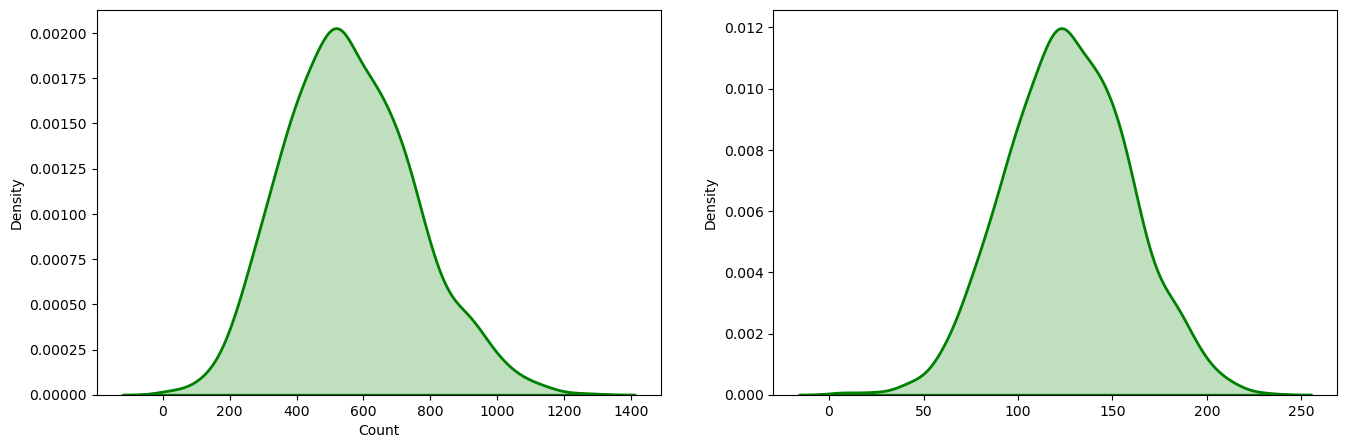

In [7]:
original_data = df.reset_index().Count
fitted_data, fitted_lambda = stats.boxcox(original_data)
fig, ax = plt.subplots(1, 2)
# plotting the original data(non-normal) and
# fitted data (normal)
sns.distplot(original_data, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Non-Normal", color ="green", ax = ax[0])
 
sns.distplot(fitted_data, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Normal", color ="green", ax = ax[1])
 
 
# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(16)

Text(0.5, 1.0, 'Serie con Box-Cox')

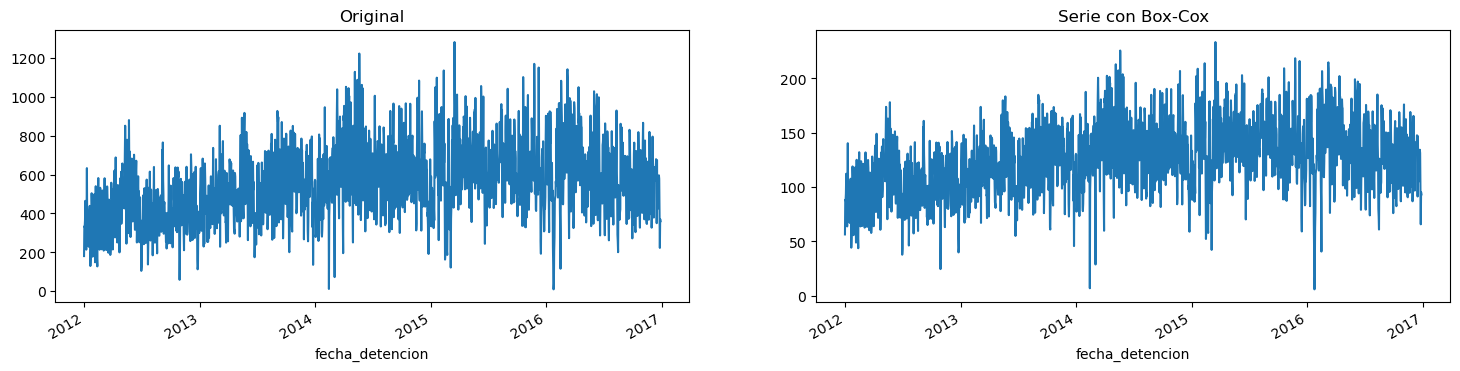

In [8]:
fig, ax = plt.subplots(1,2,figsize=(18,4))
df.plot(ax=ax[0])

temp = df.reset_index()
temp["fitted_data"] = fitted_data
fitted_data = temp.set_index(pd.DatetimeIndex(temp['fecha_detencion']))["fitted_data"]
pd.Series(fitted_data).plot(ax=ax[1])

ax[0].set_title("Original")
ax[1].set_title("Serie con Box-Cox")

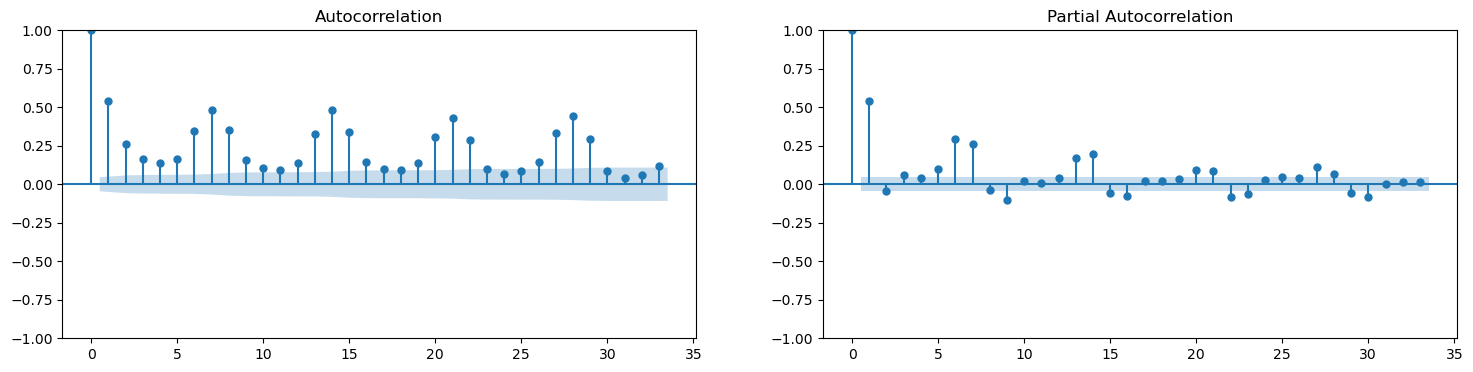

In [9]:
fig, ax = plt.subplots(1,2,figsize=(18,4))
plot_acf(fitted_data, ax=ax[0])
plot_pacf(fitted_data, method='ywm', ax=ax[1]);

In [10]:
adfuller(fitted_data)

(-4.154445025391664,
 0.000786181151277074,
 25,
 1796,
 {'1%': -3.433996253313391,
  '5%': -2.863150617970021,
  '10%': -2.5676274409973163},
 16502.21901889492)

In [11]:
kpss(fitted_data)

(4.614450534201475,
 0.01,
 19,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

#### Media Movil

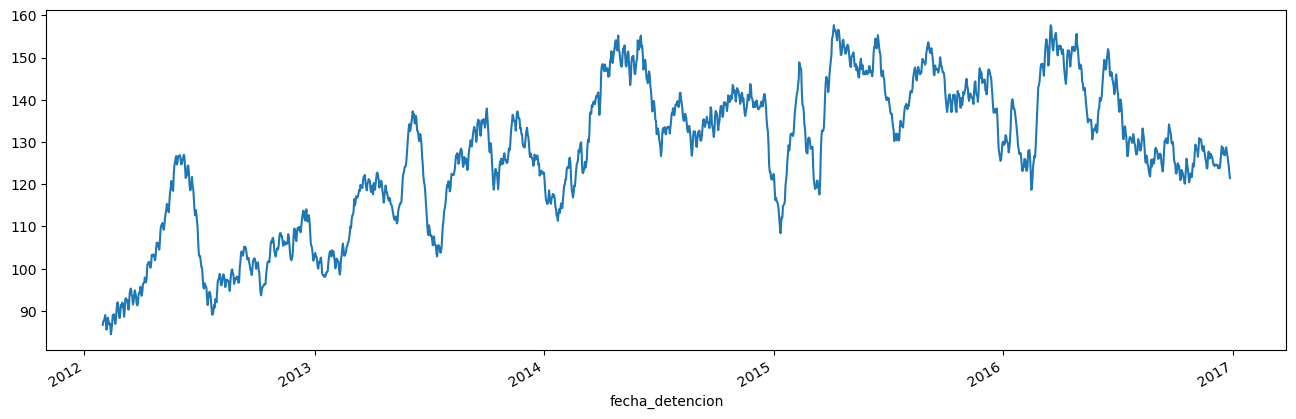

In [12]:
media_movil = pd.Series(fitted_data).rolling(30).mean()
media_movil.dropna(inplace=True)
media_movil.plot()
plt.show()

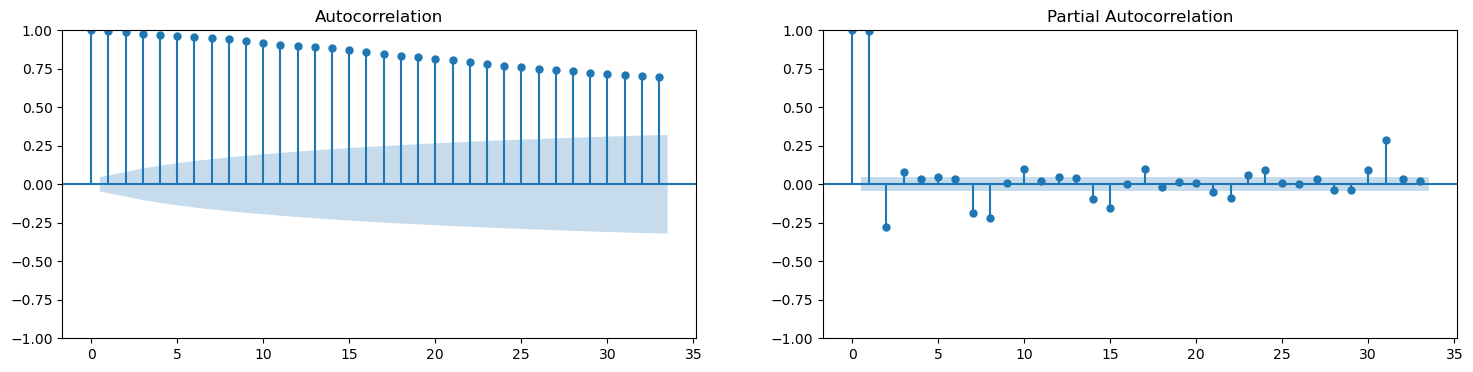

In [13]:
fig, ax = plt.subplots(1,2,figsize=(18,4))
plot_acf(media_movil, ax=ax[0])
plot_pacf(media_movil, method='ywm', ax=ax[1]);

In [14]:
adfuller(media_movil)

(-3.1783387160658934,
 0.02127325838534842,
 23,
 1769,
 {'1%': -3.4340519866364954,
  '5%': -2.8631752211631247,
  '10%': -2.5676405414939345},
 5465.41310649994)

In [15]:
kpss(media_movil)

(3.8374681364498167,
 0.01,
 27,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

### Diferenciación

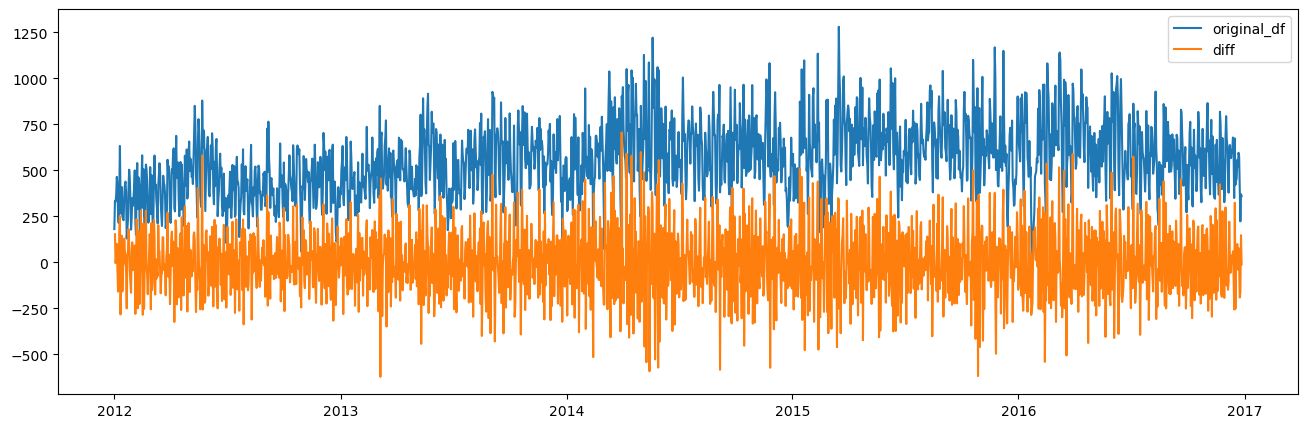

In [16]:
dataset=original_data

diff = df.diff(1)
    
plt.plot(df)
plt.plot(diff)
plt.legend(['original_df','diff'])
plt.show()

In [17]:
diff = diff.dropna()
diff.head()

fecha_detencion
2012-01-02    153.0
2012-01-03     -4.0
2012-01-04     34.0
2012-01-05    101.0
2012-01-06    -42.0
Name: Count, dtype: float64

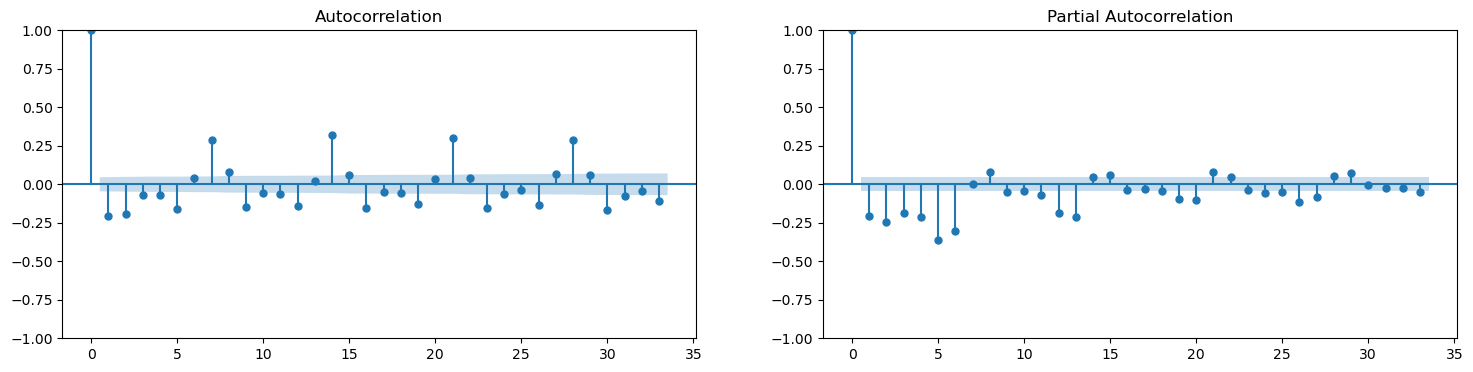

In [18]:
fig, ax = plt.subplots(1,2,figsize=(18,4))
plot_acf(diff, ax=ax[0])
plot_pacf(diff, method='ywm', ax=ax[1]);

In [19]:
adfuller(diff)

(-14.014072231496838,
 3.669589586856322e-26,
 25,
 1795,
 {'1%': -3.4339982875683357,
  '5%': -2.863151515989605,
  '10%': -2.567627919165742},
 22906.607275655348)

In [20]:
kpss(diff)

(0.0701210692793189,
 0.1,
 63,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

### Logarítmica con diferenciacion

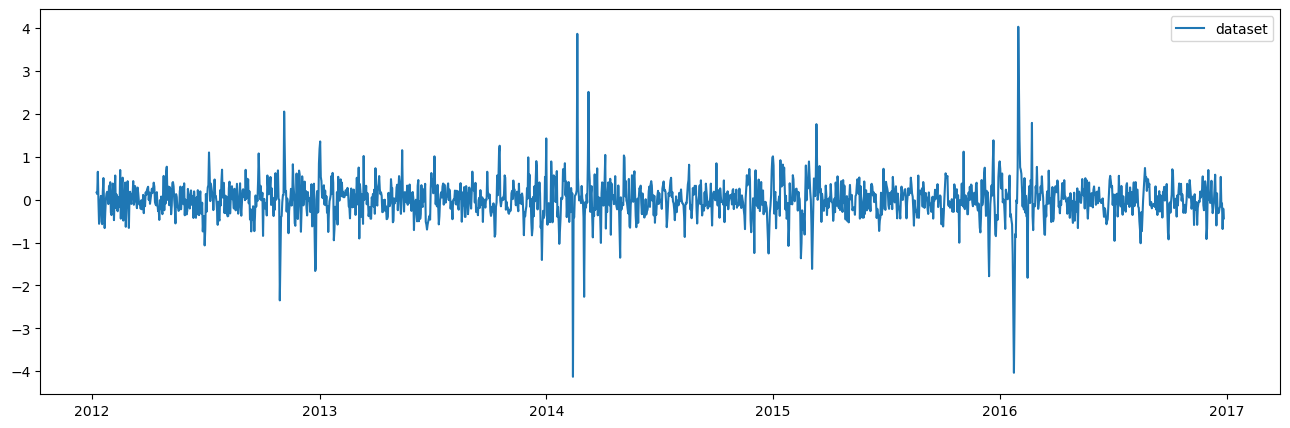

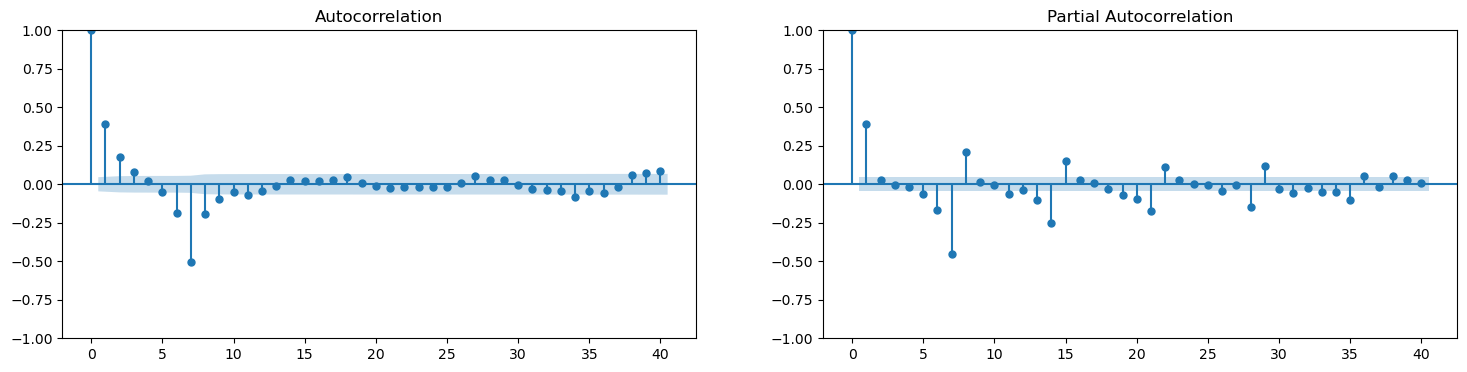

In [25]:
dataset = np.log(df)
diff = dataset.diff(7).dropna()

plt.plot(diff)
plt.legend(['dataset'])
plt.show()

fig, ax = plt.subplots(1,2,figsize=(18,4))
plot_acf(diff, ax=ax[0], lags=40)
plot_pacf(diff, method='ywm', ax=ax[1], lags=40);

In [22]:
adfuller(diff)

(-13.083296915248509,
 1.8517075610231567e-24,
 21,
 1793,
 {'1%': -3.434002362895342,
  '5%': -2.863153315036348,
  '10%': -2.5676288771043367},
 1052.7814940882604)

In [23]:
kpss(diff)

(0.018690954793363974,
 0.1,
 11,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

### Observaciones   

El mejor valor de adfuller y kpss para la determinación de la estacionariedad de la serie es aplicando una transformación logarítmica y luego una diferenciación de 7 dias.